<img src="https://raw.githubusercontent.com/FrederickMappin/alphagenomeEZ/main/icon1.png" height="200" align="right" style="height:240px">

# **alphagenomeEZbatch v1.0.0: Making alphagenome accessible to all**


AlphaGenomeEZ is a simplified implementation of the [google-deepmind/alphagenome](https://github.com/google-deepmind/alphagenome) meant to make the genome accessible to everyone.

For more details, see <a href="#Instructions">bottom</a> of the notebook and checkout the [AlphaGenomeEZ GitHub](https://github.com/sokrypton/ColabFold).

The offical colab notebook from [google-deepmind/alphagenome](https://colab.research.google.com/github/google-deepmind/alphagenome/blob/main/colabs/quick_start.ipynb#scrollTo=TZbfcADGkYVu)


Versions History:

Notebook Developer : [FrederickMappin](https://github.com/FrederickMappin)

Required API key can be obtained:[Get API key](https://deepmind.google.com/science/alphagenome/)


# **STEP 1: REQUIRED SET-UP**

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome
from IPython.display import clear_output
! pip install alphagenome
! pip install pyliftover

clear_output()


In [2]:
# @title Setup and imports
# @markdown Run cell to import libraries
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import data_table
from google.colab import files
from pyliftover import LiftOver
from tqdm import tqdm
from io import StringIO
data_table.enable_dataframe_formatter()

HG38_GTF_FEATHER = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

In [3]:
# @title API Key Input
# @markdown Alphagenome require API key to use. Provide key throught Google Colab Secrets Key [ALPHA_GENOME_API_KEY] or Directly.
import getpass
import os

api_key_option = "API KEY: Secrets" # @param ["API KEY: Secrets", "Enter API Key Directly"]

if api_key_option == "API KEY: Secrets":
  from google.colab import userdata
  api_key = userdata.get('ALPHA_GENOME_API_KEY')
elif api_key_option == "Enter API Key Directly":
  api_key = getpass.getpass("Enter your API Key value: ")
  os.environ["ALPHA_GENOME_API_KEY"] = api_key
api_key
dna_model = dna_client.create(api_key)

# **Step2: Prepare Variant CSV**

In [4]:
# @markdown Provide the CSV of variant information; be sure to include if hg19 or hg38. Running cell will liftover hg19 to hg38.
# Set your file path here, or leave as 'demo' for example data
variant_file_path = '/content/VCF3.csv'  # @param {type:"string"}
build = 'hg19(GRCh37)'  # @param ["hg38(GRCh38)","hg19(GRCh37)"]{ type:"string" }

if not variant_file_path or variant_file_path.lower() == 'demo':
    # Demo data
    variant_file_content = """variant_id\tCHROM\tPOS\tREF\tALT
chr3_58394738_A_T_b38\tchr3\t58394738\tA\tT
chr8_28520_G_C_b38\tchr8\t28520\tG\tC
chr16_636337_G_A_b38\tchr16\t636337\tG\tA
chr16_1135446_G_T_b38\tchr16\t1135446\tG\tT
"""
    vcf = pd.read_csv(StringIO(variant_file_content), sep='\t')
else:
    ext = os.path.splitext(variant_file_path)[1].lower()
    if ext == '.csv':
        vcf = pd.read_csv(variant_file_path)
    elif ext == '.vcf':
        with open(variant_file_path) as f:
            lines = [line for line in f if not line.startswith('#')]
        vcf = pd.read_csv(StringIO(''.join(lines)), sep='\t')
    else:
        raise ValueError('Unsupported file format. Please provide a .csv or .vcf file.')

# Only perform liftover if build is hg19(GRCh37)
if build == 'hg19(GRCh37)':
    lo = LiftOver('hg19', 'hg38')
    def liftover_row(row):
        chrom = str(row['CHROM'])
        if not chrom.lower().startswith('chr'):
            chrom = f'chr{chrom}'
        result = lo.convert_coordinate(chrom, int(row['POS']) - 1)
        if result:
            new_chrom, new_pos, _, _ = result[0]
            row['CHROM'] = new_chrom
            row['POS'] = int(new_pos) + 1
        else:
            row['CHROM'] = None
            row['POS'] = None
        return row
    vcf = vcf.apply(liftover_row, axis=1)
    vcf = vcf.dropna(subset=['CHROM', 'POS'])

# vcf is now ready for downstream analysis

In [6]:
# @markdown Verify liftover and Variants.
vcf

,variant_id,CHROM,POS,REF,ALT,Gene,Build
0,Jurkathg19,chr1,47239296,C,CCGTTTCCTAACC,NaN,NaN
1,Jurkathg38,chr2,47012157,C,CCGTTTCCTAACC,NaN,NaN
2,rs2293765,chr2,190656119,A,C,NAB1,hg19


# **Step3: Context Window and Modalities**
Tip: Select download to get a CSV that can be used for more custom advanced plotting outside the scope of this notebook.

In [7]:
# @title Score Multiple Variants from VCF { run: "auto" }

organism = 'human'  # @param ["human"] {type:"string"}
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
}
organism = organism_map[organism]

# @markdown Specify length of sequence around variant to predict:
sequence_length = '1MB'  # @param ["2KB", "16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# @markdown Additional settings:
download_all_predictions = False  # @param { type: "boolean" }

# Dictionary to store dataframes for each variant
variant_dataframes = {}
failed_variants = []

print(f"Processing {len(vcf)} variants...")

# Process each variant in the VCF
for idx, row in tqdm(vcf.iterrows(), total=len(vcf), desc="Scoring variants"):
    try:
        # Create variant object from VCF row
        variant = genome.Variant(
            chromosome=str(row['CHROM']),
            position=int(row['POS']),
            reference_bases=str(row['REF']),
            alternate_bases=str(row['ALT']),
        )

        # Create interval centered on the variant
        interval = variant.reference_interval.resize(sequence_length)

        # Score the variant
        variant_scores = dna_model.score_variant(
            interval=interval,
            variant=variant,
            variant_scorers=list(variant_scorers.RECOMMENDED_VARIANT_SCORERS.values()),
        )

        # Convert to dataframe
        df_scores = variant_scorers.tidy_scores(variant_scores)

        # Store in dictionary using variant_id as key
        if 'variant_id' in row:
            variant_key = row['variant_id']
        else:
            variant_key = f"{row['CHROM']}_{row['POS']}_{row['REF']}_{row['ALT']}"

        variant_dataframes[variant_key] = df_scores

        # Optional: Download individual CSV files
        if download_all_predictions:
            df_scores.to_csv(f'{variant_key}_scores.csv', index=False)

        print(f"✓ Successfully scored variant: {variant_key}")

    except Exception as e:
        variant_key = f"{row['CHROM']}_{row['POS']}_{row['REF']}_{row['ALT']}" if 'variant_id' not in row else row['variant_id']
        failed_variants.append({
            'variant_id': variant_key,
            'error': str(e)
        })
        print(f"✗ Failed to score variant {variant_key}: {e}")

print(f"\nProcessing complete!")
print(f"Successfully scored: {len(variant_dataframes)} variants")
print(f"Failed variants: {len(failed_variants)}")

if failed_variants:
    print("\nFailed variants:")
    for failed in failed_variants:
        print(f"  - {failed['variant_id']}: {failed['error']}")

# Display summary of available variant dataframes
print(f"\nAvailable variant dataframes:")
for variant_id in list(variant_dataframes.keys())[:10]:  # Show first 10
    num_scores = len(variant_dataframes[variant_id])
    print(f"  - {variant_id}: {num_scores} scores")
if len(variant_dataframes) > 10:
    print(f"  ... and {len(variant_dataframes) - 10} more variants")

Processing 3 variants...


Scoring variants:  33%|███▎      | 1/3 [00:02<00:04,  2.45s/it]

✓ Successfully scored variant: Jurkathg19


Scoring variants:  67%|██████▋   | 2/3 [00:05<00:02,  2.60s/it]

✓ Successfully scored variant: Jurkathg38


Scoring variants: 100%|██████████| 3/3 [00:07<00:00,  2.49s/it]

✓ Successfully scored variant: rs2293765

Processing complete!
Successfully scored: 3 variants
Failed variants: 0

Available variant dataframes:
  - Jurkathg19: 32898 scores
  - Jurkathg38: 31596 scores
  - rs2293765: 28737 scores


In [8]:
# @title View Variant Score Table
# @markdown Select and view the scoring data table for any variant

if 'variant_dataframes' in globals() and variant_dataframes:
    available_variants = list(variant_dataframes.keys())
    print("Available variants for table viewing:")
    for i, variant_id in enumerate(available_variants):
        print(f"{i}. {variant_id}")

    # @markdown Choose variant to view table:
    selected_table_variant = available_variants[0]  # @param

    if selected_table_variant in variant_dataframes:
        print(f"\n📊 Viewing score table for variant: {selected_table_variant}")

        # Get the dataframe for the selected variant
        variant_df = variant_dataframes[selected_table_variant]

        # Display basic info
        print(f"Total scores: {len(variant_df)}")
        print(f"Columns: {', '.join(variant_df.columns.tolist())}")

        # Display the complete table
        if len(variant_df) > 0:
            display(variant_df)
        else:
            print("⚠️ No data found in this variant's table.")

    else:
        print(f"❌ Variant {selected_table_variant} not found in available variants")

else:
    print("❌ No variant dataframes found. Run the variant scoring cell first.")

Available variants for table viewing:
0. Jurkathg19
1. Jurkathg38
2. rs2293765

📊 Viewing score table for variant: Jurkathg19
Total scores: 32898
Columns: variant_id, scored_interval, gene_id, gene_name, gene_type, gene_strand, junction_Start, junction_End, output_type, variant_scorer, track_name, track_strand, Assay title, ontology_curie, biosample_name, biosample_type, biosample_life_stage, data_source, endedness, genetically_modified, transcription_factor, histone_mark, gtex_tissue, raw_score, quantile_score


,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.755438,0.998161
1,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,in_vitro_differentiated_cells,adult,encode,paired,False,NaN,NaN,NaN,-0.239799,-0.970426
2,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.840644,0.997839
3,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.480721,0.998361
4,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.819778,0.997279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32893,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,1.812975,0.868972
32894,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,217.649033,0.992014
32895,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,0.569825,0.738510
32896,chr1:47239296:C>CCGTTTCCTAACC,chr1:46715008-47763584:.,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",...,primary_cell,NaN,encode,NaN,False,NaN,NaN,NaN,3.375423,0.895266


# **STEP 4. FIND CELL OR TISSUE TYPE OF INTEREST**

In [ ]:
# @title Find Ontology Terms of Interest

# @markdown Click Filter on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the Search by all fields box to find the ontology_curie term corresponding to a tissue and output type of interest. Use https://www.ebi.ac.uk/ols4/ to search for relevant ontology_curie terms to filter from.
from alphagenome import colab_utils
from alphagenome.models import dna_client
from google.colab import data_table
import pandas as pd

data_table.enable_dataframe_formatter()
output_metadata = dna_model.output_metadata(
    dna_client.Organism.HOMO_SAPIENS
).concatenate()

output_metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,nonzero_mean,output_type,gtex_tissue,histone_mark,transcription_factor
0,CL:0000084 ATAC-seq,.,ATAC-seq,CL:0000084,T-cell,primary_cell,adult,encode,paired,False,0.739741,OutputType.ATAC,NaN,NaN,NaN
1,CL:0000100 ATAC-seq,.,ATAC-seq,CL:0000100,motor neuron,in_vitro_differentiated_cells,adult,encode,paired,False,0.273136,OutputType.ATAC,NaN,NaN,NaN
2,CL:0000236 ATAC-seq,.,ATAC-seq,CL:0000236,B cell,primary_cell,adult,encode,paired,False,4.700081,OutputType.ATAC,NaN,NaN,NaN
3,CL:0000623 ATAC-seq,.,ATAC-seq,CL:0000623,natural killer cell,primary_cell,adult,encode,paired,False,0.938715,OutputType.ATAC,NaN,NaN,NaN
4,CL:0000624 ATAC-seq,.,ATAC-seq,CL:0000624,"CD4-positive, alpha-beta T cell",primary_cell,adult,encode,paired,False,4.365206,OutputType.ATAC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,ENCSR182QNJ,-,PRO-cap,EFO:0001099,Caco-2,cell_line,NaN,encode,NaN,False,14.002803,OutputType.PROCAP,NaN,NaN,NaN
8,ENCSR740IPL,-,PRO-cap,EFO:0002067,K562,cell_line,NaN,encode,NaN,False,15.765458,OutputType.PROCAP,NaN,NaN,NaN
9,ENCSR797DEF,-,PRO-cap,EFO:0002819,Calu3,cell_line,NaN,encode,NaN,False,12.281321,OutputType.PROCAP,NaN,NaN,NaN
10,ENCSR801ECP,-,PRO-cap,CL:0002618,endothelial cell of umbilical vein,primary_cell,NaN,encode,NaN,False,13.973692,OutputType.PROCAP,NaN,NaN,NaN


In [9]:
# @title Select Variant for Visualization

# Display available variants and create dropdown options
if 'variant_dataframes' in globals() and variant_dataframes:
    available_variants = list(variant_dataframes.keys())
    print("Available variants:")
    for i, variant_id in enumerate(available_variants):
        print(f"{i}. {variant_id}")

    # @markdown Choose variant from dropdown:
    # Create dropdown with available variants
    if len(available_variants) > 0:
        # For Google Colab, we'll create the parameter dynamically
        # Default to first variant
        selected_variant_id = available_variants[0]  # @param

        # In Colab, you can modify this to be a proper dropdown by changing the @param line to:
        # selected_variant_id = "chr3_58394738_A_T_b38" #@param ["chr3_58394738_A_T_b38", "chr8_28520_G_C_b38", "chr16_636337_G_A_b38", "chr16_1135446_G_T_b38"]

        print(f"\nSelected variant: {selected_variant_id}")
    else:
        selected_variant_id = None
        print("No variants available")

    # Get the variant info from VCF to recreate variant and interval objects
    if selected_variant_id:
        selected_vcf_row = None
        for idx, row in vcf.iterrows():
            if ('variant_id' in row and row['variant_id'] == selected_variant_id) or \
               (f"{row['CHROM']}_{row['POS']}_{row['REF']}_{row['ALT']}" == selected_variant_id):
                selected_vcf_row = row
                break

        if selected_vcf_row is not None:
            # Recreate variant and interval for visualization
            variant = genome.Variant(
                chromosome=str(selected_vcf_row['CHROM']),
                position=int(selected_vcf_row['POS']),
                reference_bases=str(selected_vcf_row['REF']),
                alternate_bases=str(selected_vcf_row['ALT']),
            )
            interval = variant.reference_interval.resize(sequence_length)
            print(f"✓ Ready to visualize: {variant}")
        else:
            print(f"✗ Error: Could not find {selected_variant_id} in VCF data")

else:
    print("No variant dataframes found. Run the variant scoring cell first.")

Available variants:
0. Jurkathg19
1. Jurkathg38
2. rs2293765

Selected variant: Jurkathg19
✓ Ready to visualize: chr1:47239296:C>CCGTTTCCTAACC


📊 Visualizing variant: chr1:47239296:C>CCGTTTCCTAACC
Requested plot for output ATAC but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CAGE but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CHIP_TF but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CONTACT_MAPS but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
✓ Visualization complete for variant: Jurkathg19


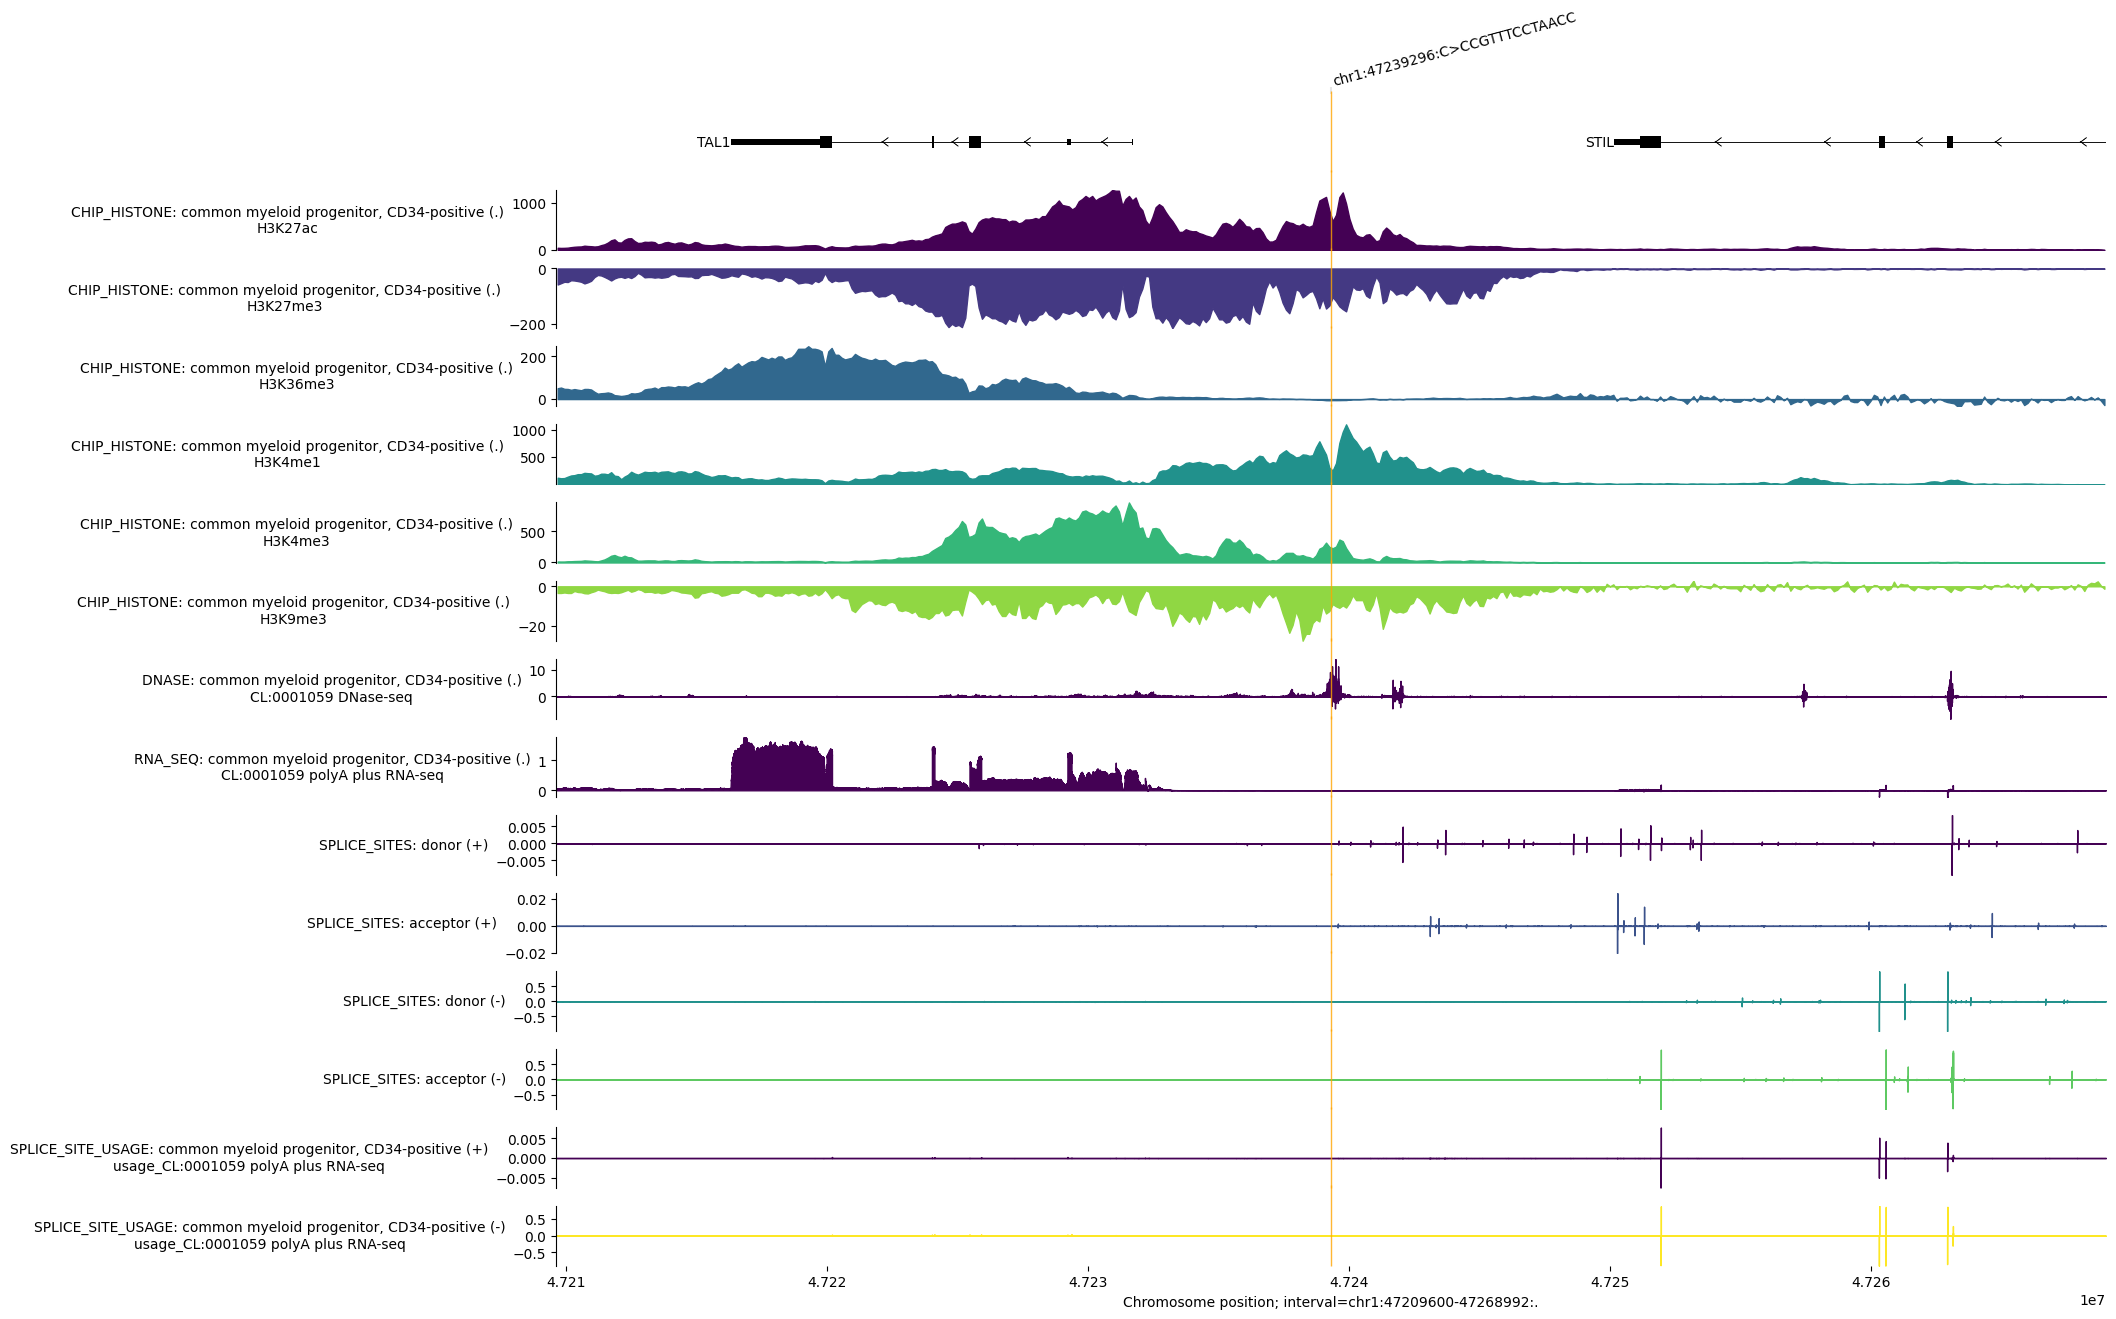

In [12]:
# @title Visualize variant effects { run: "auto" }
# @markdown We can also visualise the predicted effects of the variant by first predicting tracks for the REF and ALT alleles:

# Check if variant selection was completed
if 'variant' not in locals() or 'interval' not in locals():
    print("❌ Error: No variant selected for visualization!")
    print("Please run the 'Select Variant for Visualization' cell first.")
else:
    print(f"📊 Visualizing variant: {variant}")

    # @markdown Specify list of cell and tissue ontologies:
    ontology_terms = ['CL:0001059']  # @param

    # @markdown Gene and transcript annotation options:
    plot_gene_annotation = True  # @param { type: "boolean" }
    plot_longest_transcript_only = True  # @param { type: "boolean" }

    # @markdown Output types to plot (if present in output):
    plot_rna_seq = True  # @param { type: "boolean" }
    plot_cage = True  # @param { type: "boolean" }
    plot_atac = True  # @param { type: "boolean" }
    plot_dnase = True  # @param { type: "boolean" }
    plot_chip_histone = True  # @param { type: "boolean" }
    plot_chip_tf = True  # @param { type: "boolean" }
    plot_splice_sites = True  # @param { type: "boolean" }
    plot_splice_site_usage = True  # @param { type: "boolean" }
    plot_contact_maps = True  # @param { type: "boolean" }
    plot_splice_junctions = True  # @param { type: "boolean" }

    # @markdown Option to filter tracks to only a specific DNA strand:
    filter_to_positive_strand = False  # @param { type: "boolean" }
    filter_to_negative_strand = False  # @param { type: "boolean" }
    if filter_to_positive_strand and filter_to_negative_strand:
        raise ValueError(
            'Cannot specify both filter_to_positive_strand and '
            'filter_to_negative_strand.'
        )

    # @markdown Specify a list of Transription Factors to select from CHIP_TF outputs e.g. ['IKZF1'].
    # These must be contained in the 'transcription_factor' column of the CHIP_TF metadata.
    transcription_factors = None  # @param

    # @markdown Other visualization options:
    ref_color = 'dimgrey'  # @param { type: "string" }
    alt_color = 'red'  # @param { type: "string" }
    ref_alt_colors = {'REF': ref_color, 'ALT': alt_color}
    plot_interval_width = 59392 # @param { type: "slider", min: 2048, max: 1048576, step: 2048}
    plot_interval_shift = 0 # @param { type: "slider", min: -524288, max: 524288, step: 2048}

    # Initialize caches for transcript extractors and predictions
    if '_transcript_extractor_cache' not in globals():
        _transcript_extractor_cache = {}
    if '_prediction_cache' not in globals():
        _prediction_cache = {}

    # Define GTF paths for different organisms
    HG38_GTF_FEATHER = (
        'https://storage.googleapis.com/alphagenome/reference/gencode/'
        'hg38/gencode.v46.annotation.gtf.gz.feather'
    )
    MM10_GTF_FEATHER = (
        'https://storage.googleapis.com/alphagenome/reference/gencode/'
        'mm10/gencode.vM33.annotation.gtf.gz.feather'
    )

    # Load gene annotation.
    if organism in _transcript_extractor_cache:
        transcript_extractor, longest_transcript_extractor = (
            _transcript_extractor_cache[organism]
        )
    else:
        match organism:
            case dna_client.Organism.HOMO_SAPIENS:
                gtf_path = HG38_GTF_FEATHER
            case dna_client.Organism.MUS_MUSCULUS:
                gtf_path = MM10_GTF_FEATHER
            case _:
                raise ValueError(f'Unsupported organism: {organism}')

        gtf = pd.read_feather(gtf_path)

        # Filter to protein-coding genes and highly supported transcripts.
        gtf_transcript = gene_annotation.filter_transcript_support_level(
            gene_annotation.filter_protein_coding(gtf), ['1']
        )

        # Extractor for identifying transcripts in a region.
        transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcript)

        # Also define an extractor that fetches only the longest transcript per gene.
        gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
            gtf_transcript
        )
        longest_transcript_extractor = transcript_utils.TranscriptExtractor(
            gtf_longest_transcript
        )
        _transcript_extractor_cache[organism] = (
            transcript_extractor,
            longest_transcript_extractor,
        )


    def _predict_variant_cached(
        interval, variant, organism, requested_outputs, ontology_terms
    ):
        """Cache wrapper of dna_model.predict_variant."""
        # Create a unique key from the function arguments.
        cache_key = (
            str(interval),
            str(variant),
            str(organism),
            tuple(requested_outputs),
            tuple(ontology_terms),
        )

        # Check if the result is already in the cache.
        if cache_key in _prediction_cache:
            return _prediction_cache[cache_key]

        # If not, compute the prediction and store it in the cache.
        result = dna_model.predict_variant(
            interval=interval,
            variant=variant,
            organism=organism,
            requested_outputs=requested_outputs,
            ontology_terms=ontology_terms,
        )
        _prediction_cache[cache_key] = result
        return result


    output = _predict_variant_cached(
        interval=interval,
        variant=variant,
        organism=organism,
        requested_outputs=[*dna_client.OutputType],
        ontology_terms=ontology_terms,
    )

    # Filter to DNA strand if requested.
    ref, alt = output.reference, output.alternate

    if filter_to_positive_strand:
        ref = ref.filter_to_strand(strand='+')
        alt = alt.filter_to_strand(strand='+')
    elif filter_to_negative_strand:
        ref = ref.filter_to_strand(strand='-')
        alt = alt.filter_to_strand(strand='-')

    # Function to filter to TFs if requested.
    def _maybe_filter_to_tfs(
        tdata,
    ):
        if not plot_chip_tf:
            return tdata

        if plot_chip_tf and (transcription_factors is not None):
            if not isinstance(transcription_factors, list):
                raise ValueError('TFs must be input as a list of strings.')
            if not isinstance(transcription_factors[0], str):
                raise ValueError('TFs must be input as a list of strings.')

        if transcription_factors is None:
            return tdata

        tf_rows = tdata.metadata.index[
            tdata.metadata['transcription_factor'].isin(transcription_factors)
        ]
        if not tf_rows.any():
            print(
                f'No tracks found for specified transcription factors and'
                f' ontology_terms.'
            )
            return None
        missing_tfs = set(transcription_factors).difference(
            set(tdata.metadata['transcription_factor'])
        )
        if missing_tfs:
            print(
                f'Could not find tracks in chip_tf outputs corresponding to the'
                f' following requested TFs'
            )
        return tdata.select_tracks_by_index(tf_rows)


    # Build plot.
    components = []

    # Gene and transcript annotation.
    if plot_gene_annotation:
        if plot_longest_transcript_only:
            transcripts = longest_transcript_extractor.extract(interval)
        else:
            transcripts = transcript_extractor.extract(interval)
        components.append(plot_components.TranscriptAnnotation(transcripts))


    # Individual output type plots using difference plots (ALT - REF)
    plot_map = {
        'plot_atac': (ref.atac, alt.atac, 'ATAC'),
        'plot_cage': (ref.cage, alt.cage, 'CAGE'),
        'plot_chip_histone': (ref.chip_histone, alt.chip_histone, 'CHIP_HISTONE'),
        'plot_chip_tf': (
            _maybe_filter_to_tfs(ref.chip_tf),
            _maybe_filter_to_tfs(alt.chip_tf),
            'CHIP_TF',
        ),
        'plot_contact_maps': (ref.contact_maps, alt.contact_maps, 'CONTACT_MAPS'),
        'plot_dnase': (ref.dnase, alt.dnase, 'DNASE'),
        'plot_rna_seq': (ref.rna_seq, alt.rna_seq, 'RNA_SEQ'),
        'plot_splice_junctions': (
            ref.splice_junctions,
            alt.splice_junctions,
            'SPLICE_JUNCTIONS',
        ),
        'plot_splice_sites': (ref.splice_sites, alt.splice_sites, 'SPLICE_SITES'),
        'plot_splice_site_usage': (
            ref.splice_site_usage,
            alt.splice_site_usage,
            'SPLICE_SITE_USAGE',
        ),
    }

    for key, (ref_data, alt_data, output_type) in plot_map.items():
        if eval(key) and ref_data is not None and ref_data.values.shape[-1] == 0:
            print(
                f'Requested plot for output {output_type} but no tracks exist in'
                ' output. This is likely because this output does not exist for your'
                ' ontologies or requested DNA strand.'
            )
        if eval(key) and ref_data and alt_data:
            match output_type:
                case 'CHIP_HISTONE':
                    ylabel_template = (
                        f'{output_type}: {{biosample_name}} ({{strand}})\n{{histone_mark}}'
                    )
                case 'CHIP_TF':
                    ylabel_template = (
                        f'{output_type}: {{biosample_name}}'
                        ' ({strand})\n{transcription_factor}'
                    )
                case 'CONTACT_MAPS':
                    ylabel_template = f'{output_type}: {{biosample_name}} ({{strand}})'
                case 'SPLICE_SITES':
                    ylabel_template = f'{output_type}: {{name}} ({{strand}})'
                case _:
                    ylabel_template = (
                        f'{output_type}: {{biosample_name}} ({{strand}})\n{{name}}'
                    )

            if output_type == 'CONTACT_MAPS':
                component = plot_components.ContactMapsDiff(
                    tdata=alt_data - ref_data,
                    ylabel_template=ylabel_template,
                )
                components.append(component)
            elif output_type == 'SPLICE_JUNCTIONS':
                ref_plot = plot_components.Sashimi(
                    ref_data,
                    ylabel_template='REF: ' + ylabel_template,
                )
                alt_plot = plot_components.Sashimi(
                    alt_data,
                    ylabel_template='ALT: ' + ylabel_template,
                )
                components.extend([ref_plot, alt_plot])
            else:
                # Create difference plot (ALT - REF) using Tracks component
                if filter_to_negative_strand:
                    # Use filter_to_nonpositive_strand() to match the example
                    diff_data = (alt_data.filter_to_nonpositive_strand() -
                                ref_data.filter_to_nonpositive_strand())
                elif filter_to_positive_strand:
                    diff_data = (alt_data.filter_to_strand(strand='+') -
                                ref_data.filter_to_strand(strand='+'))
                else:
                    diff_data = alt_data - ref_data

                component = plot_components.Tracks(
                    tdata=diff_data,
                    ylabel_template=ylabel_template,
                    filled=True,
                )
                components.append(component)

    if plot_interval_width > interval.width:
        raise ValueError(
            f'plot_interval_width ({plot_interval_width}) must be less than '
            f'interval.width ({interval.width}).'
        )

    plot = plot_components.plot(
        components=components,
        interval=interval.shift(plot_interval_shift).resize(plot_interval_width),
        annotations=[
            plot_components.VariantAnnotation([variant]),
        ],
    )

    print(f"✓ Visualization complete for variant: {selected_variant_id}")
    plt.show()